In [45]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray
from skimage import io

In [46]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [47]:
ear = io.imread('./data/ear.tif')
np.random.seed(42)
(length, lenx, leny) = ear.shape
print(ear.shape)
print(lenx,leny)

(21406, 245, 269)
245 269


In [48]:
#though I was going to do multiple in this file but maybe if I have multiple 
data = ear

In [49]:
def cropImage(imArr):
    (length, x, y, channel) = imArr.shape
    cropped = np.zeros((length, x-5, y+1, channel))
    for ind, im in enumerate(imArr):
        for rowind, row in enumerate(im):
            if rowind >= 5:
                row1 = np.append(row,0)
                cropped[ind][rowind-5] = row1.reshape(y+1,1)
    return cropped
            
    

In [50]:
num_data = len(data)
train_split = 0.8
num_train = int(train_split*num_data)
num_test = num_data - num_train
x_train = data[0:num_train].reshape(num_train, (lenx*leny))
x_test = data[(num_train):].reshape(num_test, (lenx*leny))

In [51]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [52]:
x_test_scaled = x_scaler.transform(x_test)

In [53]:
input_img = Input(shape=(lenx-5, leny+1, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 3), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 3), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 3), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(16, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 3))(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 3))(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 3))(x)
x = Conv2D(64, (2, 2), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [54]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 240, 270, 1)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 240, 270, 64)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 120, 135, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 120, 135, 32)      8224      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 60, 45, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 60, 45, 16)        2064      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 15, 16)        0         
__________

In [55]:
print(lenx,leny)
x_train = np.ndarray.astype(x_train_scaled.reshape((num_train, lenx,leny,1)), np.float16)
x_test = np.ndarray.astype(x_test_scaled.reshape((num_test, lenx, leny, 1)), np.float16)
print("converted")
x_train = cropImage(x_train)
x_test = cropImage(x_test)
print(x_test.shape)

245 269
converted
(4282, 240, 270, 1)


In [56]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [57]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [58]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [59]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [60]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
print(x_train.shape)

(17124, 240, 270, 1)


In [61]:
%%time
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=62,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 17124 samples, validate on 4282 samples
Epoch 1/25
17124/17124 [==============================] - 259s 15ms/step - loss: 0.4806 - val_loss: 0.4087

Epoch 00001: val_loss improved from inf to 0.40868, saving model to 23_checkpoint.keras
Epoch 2/25
17124/17124 [==============================] - 259s 15ms/step - loss: 0.4043 - val_loss: 0.3866

Epoch 00002: val_loss improved from 0.40868 to 0.38659, saving model to 23_checkpoint.keras
Epoch 3/25
17124/17124 [==============================] - 259s 15ms/step - loss: 0.3873 - val_loss: 0.3800

Epoch 00003: val_loss improved from 0.38659 to 0.38004, saving model to 23_checkpoint.keras
Epoch 4/25
17124/17124 [==============================] - 259s 15ms/step - loss: 0.3802 - val_loss: 0.3733

Epoch 00004: val_loss improved from 0.38004 to 0.37329, saving model to 23_checkpoint.keras
Epoch 5/25
17124/17124 [==============================] - 259s 15ms/step - loss: 0.3754 - val_loss: 0.3688

Epoch 00005: val_loss improved from 0.37329 to 

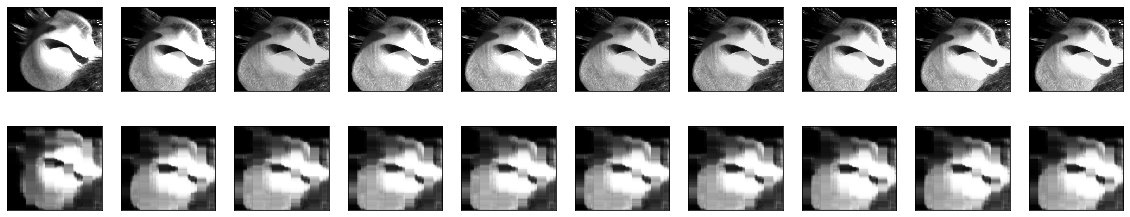

In [62]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[(i*100+20)].reshape(lenx-5, leny+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[(i*100+20)].reshape(lenx-5, leny+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [63]:
autoencoder.save('earEncoder.h5')